# Data Science Capstone - Collisions Assessment Methodology

### 1. Introduction

This notebook will describe the methodology to assess collisions data obtained from Seattle city, wich are data provided by SPD and recorded by traffic records, including all types of collisions, displayed at the intersection or mid-bloc of a segment, since 2004.

The problem consists in correctly assess a driver that wants to know the probability of get involved in an accident, based on weather conditions, road conditions and the previous history of that highway/road segment, allowing him to drive more carefully or even change course if needed.

The goal of this work is to analyze data in order to provide a model that will predict the severity of an accident/collision, given a number of features that will be extracted from the data. The model will classify and predict severity, so a driver can use this model to change course or drive more carefully, given that he isn't want to get involved into an accident, since the consequences can be unpredictable.



### 2. Data description

2.1 Imports needed

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(9,6)})

2.2 Exploratory data analysis

In [2]:
raw = pd.read_csv('Data-Collisions.csv')

C:\Python\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Drop unmatched collisions, 2,5% of rows
raw.drop(raw[raw['STATUS']!='Matched'].index, inplace = True)

In [4]:
# Discarding non critical data and generate csv to analysis
raw.drop(columns=['INCKEY','INTKEY','COLDETKEY','UNDERINFL','INATTENTIONIND','LOCATION'],inplace=True)
raw.drop(columns=['SDOT_COLCODE','SDOT_COLDESC','PERSONCOUNT', 'PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','OBJECTID'], inplace=True)
raw.drop(columns=['SEGLANEKEY','CROSSWALKKEY','REPORTNO','PEDROWNOTGRNT','SPEEDING','HITPARKEDCAR'],inplace=True)
raw.drop(columns=['SEVERITYDESC','COLLISIONTYPE','JUNCTIONTYPE','ST_COLDESC','SEVERITYCODE.1'], inplace=True)
raw.drop(columns=['STATUS','EXCEPTRSNCODE','EXCEPTRSNDESC','INCDTTM','SDOTCOLNUM'], inplace=True)

In [5]:
# Dropping where lat or long is null
raw.drop(raw[raw['X'].isnull()].index, inplace=True)

In [6]:
# Nan replacement
raw['WEATHER'].fillna('Other', inplace=True)
raw['ROADCOND'].fillna('Other', inplace=True)
raw['LIGHTCOND'].fillna('Other', inplace=True)
raw['ST_COLCODE'].fillna(31, inplace=True)
raw['ST_COLCODE'].replace(to_replace=' ',value=31, inplace=True)

In [7]:
# Data conversions
raw['ST_COLCODE'] = pd.to_numeric(raw['ST_COLCODE'])
raw['INCDATE'] = pd.to_datetime(raw['INCDATE'])
raw['WEEKDAY'] = raw['INCDATE'].apply(lambda x: x.weekday())
raw.drop(columns=['INCDATE'],inplace=True)

In [8]:
# Converting 'Unknown' to 'Other' 
raw['WEATHER'].replace(to_replace='Unknown',value='Other', inplace=True)
raw['ROADCOND'].replace(to_replace='Unknown',value='Other', inplace=True)
raw['LIGHTCOND'].replace(to_replace='Unknown',value='Other', inplace=True)

In [9]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184601 entries, 0 to 194672
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   SEVERITYCODE  184601 non-null  int64  
 1   X             184601 non-null  float64
 2   Y             184601 non-null  float64
 3   ADDRTYPE      184601 non-null  object 
 4   WEATHER       184601 non-null  object 
 5   ROADCOND      184601 non-null  object 
 6   LIGHTCOND     184601 non-null  object 
 7   ST_COLCODE    184601 non-null  int64  
 8   WEEKDAY       184601 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 14.1+ MB


In [10]:
collisions = pd.DataFrame(raw)

In [11]:
collisions.head()

,SEVERITYCODE,X,Y,ADDRTYPE,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE,WEEKDAY
0,2,-122.323148,47.703140,Intersection,Overcast,Wet,Daylight,10,2
1,1,-122.347294,47.647172,Block,Raining,Wet,Dark - Street Lights On,11,2
2,1,-122.334540,47.607871,Block,Overcast,Dry,Daylight,32,3
3,1,-122.334803,47.604803,Block,Clear,Dry,Daylight,23,4
4,2,-122.306426,47.545739,Intersection,Raining,Wet,Daylight,10,2


### 3. Methodology

3.1 Explore data

In [12]:
perc_weather = pd.DataFrame(collisions['WEATHER'].value_counts()/len(collisions)*100)
perc_weather

,WEATHER
Clear,59.024057
Raining,17.342268
Overcast,14.699812
Other,8.046544
Snowing,0.484288
Fog/Smog/Smoke,0.299565
Sleet/Hail/Freezing Rain,0.060671
Blowing Sand/Dirt,0.027085
Severe Crosswind,0.013001
Partly Cloudy,0.002709


In [14]:
perc_roadcond = pd.DataFrame(collisions['ROADCOND'].value_counts()/len(collisions)*100)
perc_roadcond

,ROADCOND
Dry,66.129653
Wet,24.952736
Other,7.625636
Ice,0.637591
Snow/Slush,0.535750
Standing Water,0.055254
Sand/Mud/Dirt,0.034669
Oil,0.028711


In [15]:
perc_lightcond = pd.DataFrame(collisions['LIGHTCOND'].value_counts()/len(collisions)*100)
perc_lightcond

,LIGHTCOND
Daylight,61.528377
Dark - Street Lights On,25.629872
Other,6.985336
Dusk,3.128369
Dawn,1.312019
Dark - No Street Lights,0.786020
Dark - Street Lights Off,0.624049
Dark - Unknown Lighting,0.005959


We can see that a large number of collisions occurs at Daylight, Dry roads, at mid road and at intersections and with clear weather.

In [18]:
perc_weekday = pd.DataFrame(collisions['WEEKDAY'].value_counts()/len(collisions)*100)
perc_weekday.reset_index(inplace=True)
perc_weekday.replace({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}, inplace=True)
perc_weekday.set_index('index',inplace=True)

<AxesSubplot:xlabel='index'>

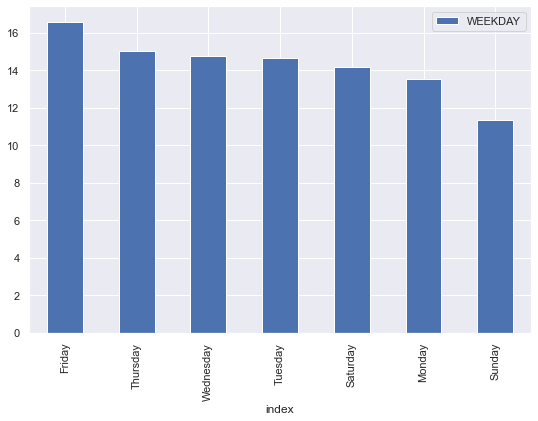

In [19]:
perc_weekday.plot(kind='bar')

Collisions occurr randomly over week days, although collisions on friday, Thursday and wednesday are more frequent. Collisions on sunday are less frequent due to less traffic volume.

In [20]:
perc_stcolcode = pd.DataFrame(collisions['ST_COLCODE'].value_counts()/len(collisions)*100)
perc_stcolcode.head(20)

,ST_COLCODE
32,23.222518
10,18.667288
14,13.575224
50,6.745359
11,6.665186
28,5.561725
13,3.917097
45,2.528155
23,2.365643
15,1.664671


We see the 20 greatest collisions codes, "One Park - one moving", "at angles" and "same direction - rear ended" represents more than half of total collisions reported

In [21]:
road_weather = collisions.pivot_table(index='ROADCOND',columns='WEATHER',values='SEVERITYCODE',aggfunc='sum',fill_value=0)

<AxesSubplot:xlabel='WEATHER', ylabel='ROADCOND'>

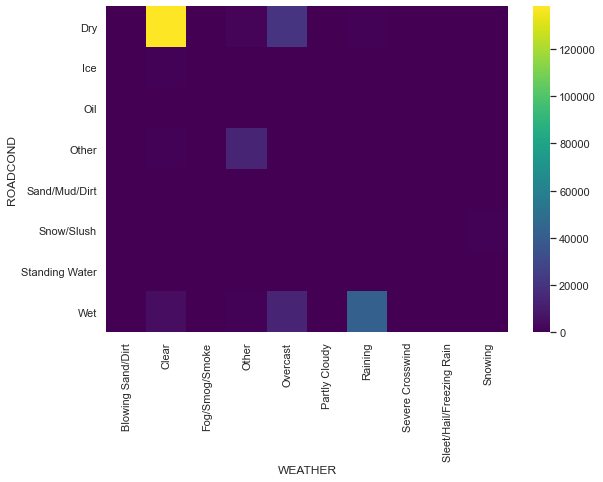

In [22]:
sns.heatmap(road_weather,cmap='viridis')

We see that Clear weather, overcast and raining are predominant factors that can cause severe accidents at dry and wet roads.

<AxesSubplot:xlabel='LIGHTCOND'>

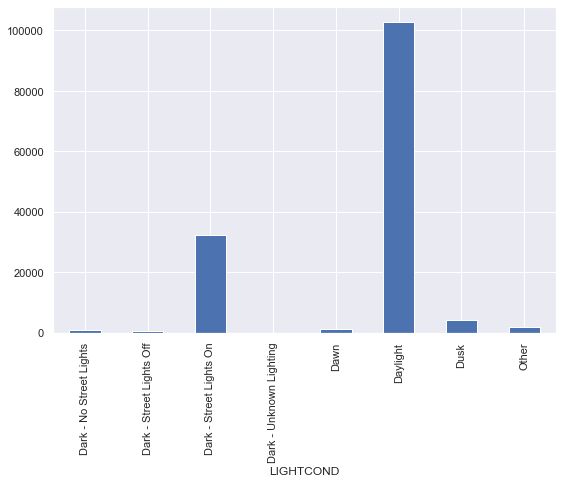

In [23]:
collisions[collisions['WEATHER']=='Clear'].groupby('LIGHTCOND')['SEVERITYCODE'].sum().plot(kind='bar')

Exploring collisions only at Clear weather, we see that light conditions that causes severe accidents are daylight and dark with street lights on.

<AxesSubplot:xlabel='ROADCOND'>

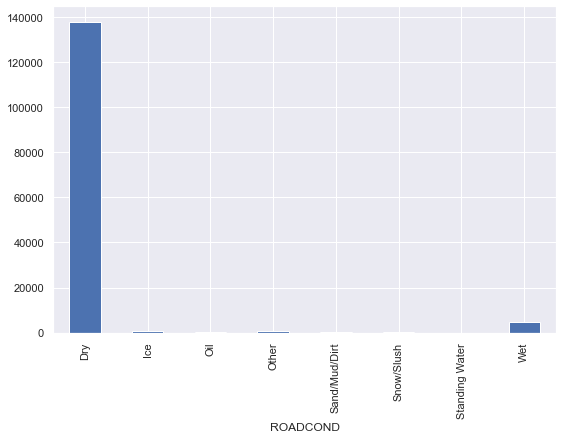

In [24]:
collisions[collisions['WEATHER']=='Clear'].groupby('ROADCOND')['SEVERITYCODE'].sum().plot(kind='bar')

Exploring collisions only at Clear weather, we see that dry road conditions are the main factor that causes severe accidents

<AxesSubplot:xlabel='ADDRTYPE'>

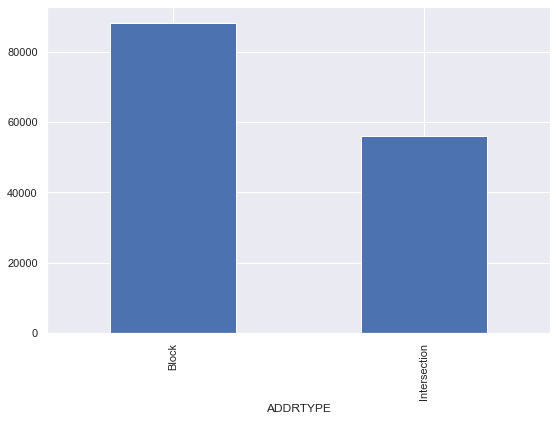

In [25]:
collisions[collisions['WEATHER']=='Clear'].groupby('ADDRTYPE')['SEVERITYCODE'].sum().plot(kind='bar')

Severe collisions are more common in block address types.

<AxesSubplot:xlabel='WEEKDAY'>

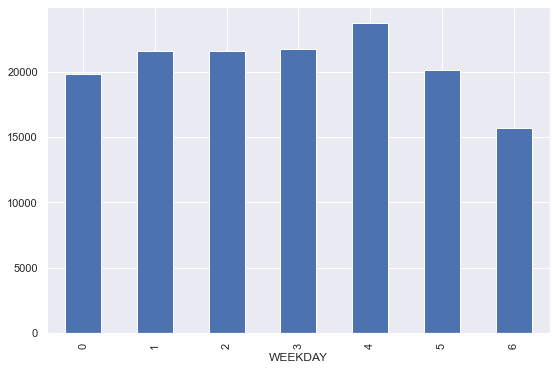

In [27]:
collisions[collisions['WEATHER']=='Clear'].groupby('WEEKDAY')['SEVERITYCODE'].sum().plot(kind='bar')

Considering Clear weather, we see that friday concentrate the more severe collisions that other week days. 

In [28]:
collisions.columns

Index(['SEVERITYCODE', 'X', 'Y', 'ADDRTYPE', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'ST_COLCODE', 'WEEKDAY'],
      dtype='object')

In [30]:
# Export to csv in order to prepare for week 3
collisions.to_csv('collisions.csv')

3.2 Define features

Given that we know week day, weather conditions, address type, road conditions and light conditions,
**predict**
severity code 
of an accident, if occurs, and determines if is more prudent change course or not drive to final destination.

3.3 Modelling

We will use a logistic regression and decision tree models to compare and classify data, in order to predict severity, based upon features described earlier. 
If severity is greater then a threshold, the driver will be informed to not drive to final destination, if the severity is intermediate, the driver will be informed to change course. Otherwise, the driver may proceed to final destination.

3.4 Evaluation

We will compare the historic data and use test train split method to create a test set and a train set, in order to be able to
correctly predict the severity, therefore, this will be a supervised learning problem.